In [1]:
import corner
import numpy as np
import json
import matplotlib.pyplot as plt

# Frequentist
import pyhf
pyhf.set_backend('jax')

# Bayesian
import pymc
import arviz

# Both
import Bayesian_pyhf
from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

%load_ext autoreload
%autoreload 

## Example 1: Adapted Public Likelihood
- Search for displaced leptons in $\sqrt s$ = 13 TeV $pp$ collisions with the ATLAS detector
- https://www.hepdata.net/record/resource/1981552?landing_page=true

In [2]:
with open(f'SRee_SRmm_Srem.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model, include_auxdata=False)
observations_inclAux = workspace.data(model)

In [3]:
model.config.poi_name

'mu_Sig'

In [4]:
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'HalfNormal_Unconstrained', 'sigma': [3]}
}

In [5]:
n_draws = 20_000

with Bayesian_pyhf.infer.model(model, unconstr_priors, observations):
    step = pymc.Metropolis()
    
    post_data = pymc.sample(draws=n_draws, chains=1, step=step)
    post_pred = pymc.sample_posterior_predictive(post_data)
    prior_pred = pymc.sample_prior_predictive(n_draws)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [lumi]
>Metropolis: [mu_Sig]
>Metropolis: [ucbSRee]
>Metropolis: [ucbSRem]
>Metropolis: [ucbSRmm]
>Metropolis: [SigXSec]
>Metropolis: [cuts_SRmm_LRT]
>Metropolis: [cuts_SRmm_LRTfilter]
>Metropolis: [ucsSRmm_Slep_1000_10]
>Metropolis: [ucsSRmm_disp]
>Metropolis: [ucsSRmm_mu_sel]
>Metropolis: [ucsSRmm_mu_trig]
>Metropolis: [ucsSRmm_pileupWeight]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


array([[<Axes: title={'center': 'lumi'}>,
        <Axes: title={'center': 'lumi'}>],
       [<Axes: title={'center': 'mu_Sig'}>,
        <Axes: title={'center': 'mu_Sig'}>],
       [<Axes: title={'center': 'SigXSec'}>,
        <Axes: title={'center': 'SigXSec'}>]], dtype=object)

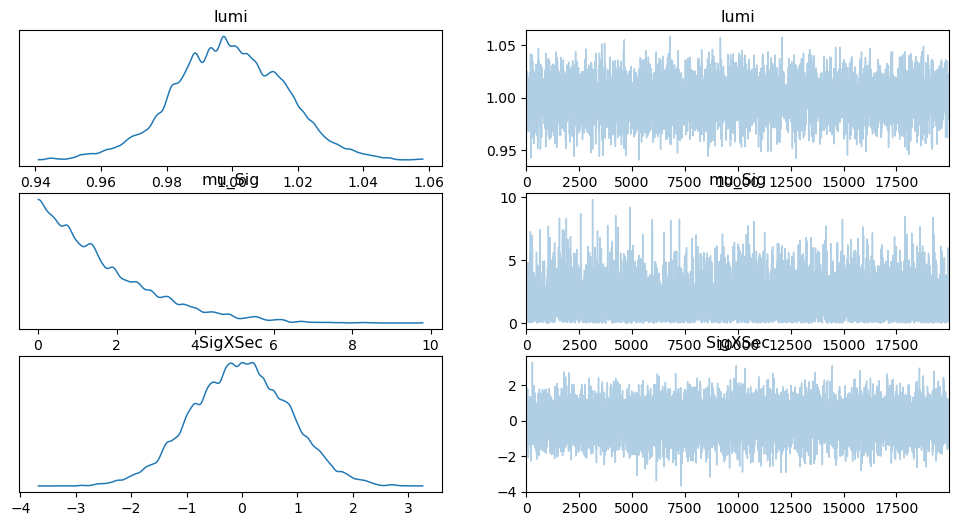

In [10]:
arviz.plot_trace(post_data, var_names=['lumi', 'mu_Sig', 'SigXSec'])

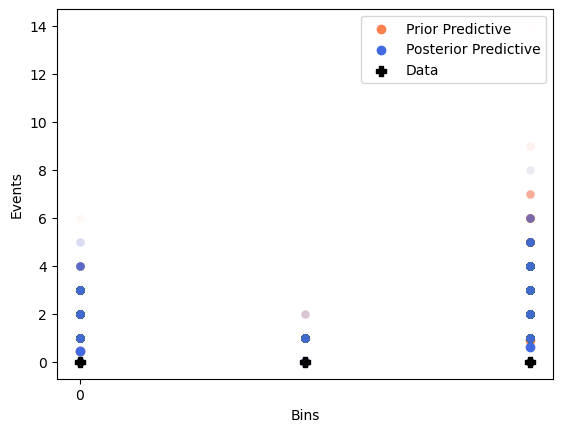

In [11]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred, bin_steps=4)


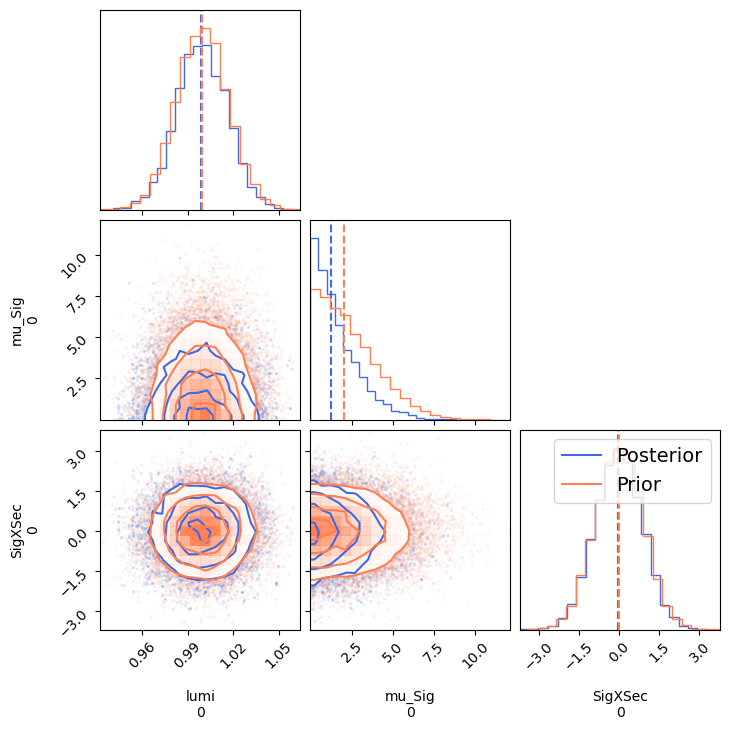

In [12]:
a = corner.corner(post_data.posterior, var_names=['lumi', 'mu_Sig', 'SigXSec'], quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=['lumi', 'mu_Sig', 'SigXSec'], quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)

## Example 2: Toy $\gamma \gamma$ to Higgs

In [53]:
with open(f'GammaGammaHiggs.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model, include_auxdata=False)
observations_inclAux = workspace.data(model)

Frequentist results:

In [54]:
fit_results = cabinetry.fit.fit(model, observations_inclAux)

print(f'MLE for mu: {fit_results.bestfit[model.config.poi_index]}')

MLE for mu: 1.113243104219725


Bayesian results:

In [55]:
unconstr_priors = {
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [1], 'beta': [1]}
}

In [56]:
n_draws = 10_000

with infer.model(model, unconstr_priors, observations):
    step = pymc.Metropolis()
    post_data = pymc.sample(draws=n_draws, chains=1, step=step)
    post_pred = pymc.sample_posterior_predictive(post_data)

    prior_pred = pymc.sample_prior_predictive(n_draws)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [NormUncertainty]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, NormUncertainty, mu]


In [57]:
print(f'Posterior mean for mu: {np.array(post_data.posterior.mu[0]).mean()}')

Posterior mean for mu: 1.099134229500847


array([[<Axes: title={'center': 'NormUncertainty'}>,
        <Axes: title={'center': 'NormUncertainty'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

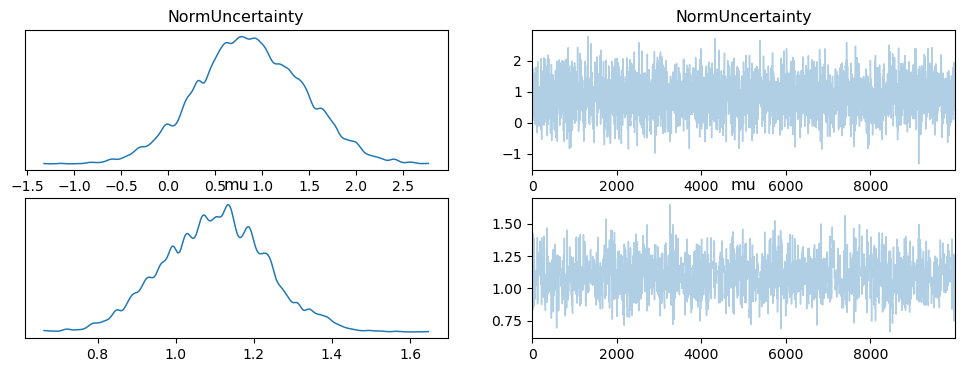

In [58]:
arviz.plot_trace(post_data)

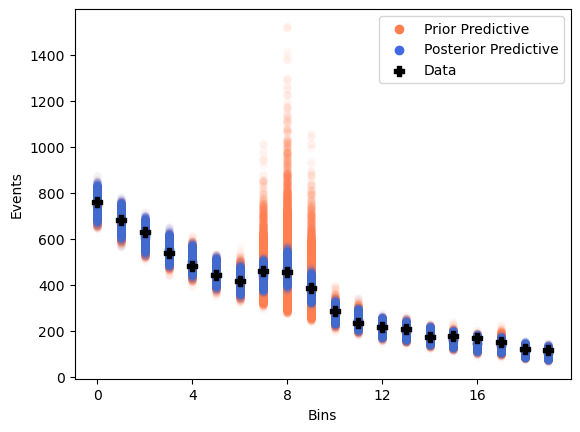

In [59]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred, bin_steps=4)
